In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from mpl_toolkits.basemap import Basemap
import scipy.signal as sig
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import autocorrelation_plot

## Load our pre-processed data.

In [2]:
t0 = time.time()
dataset_path = '/datasets/NOAA_SST/'
data = pd.read_pickle(dataset_path + 'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(dataset_path + 'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

39.02602195739746


## Look at the data

In [3]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


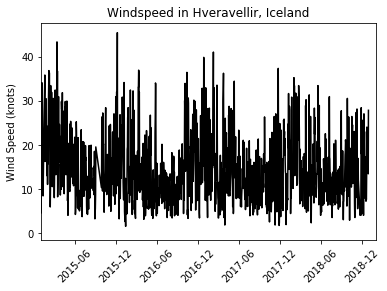

In [4]:
my_station_number = '041560'
windspeed_series = data.loc[data['stn'] == my_station_number]['wdsp'].sort_index()

plt.plot(windspeed_series.index, windspeed_series.values, color = 'k')
plt.xlim((pd.Timestamp(2015,1,1), pd.Timestamp(2019,2,1)))
plt.title('Windspeed in Hveravellir, Iceland')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=45)
plt.show()

# Where is my station located?

In [5]:
my_station = stations.loc[stations['usaf'] == my_station_number]
my_station.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
18673,041560,99999,HVERAVELLIR,IC,None,None,64.867,-19.567,+0641.0,20080115,20190401


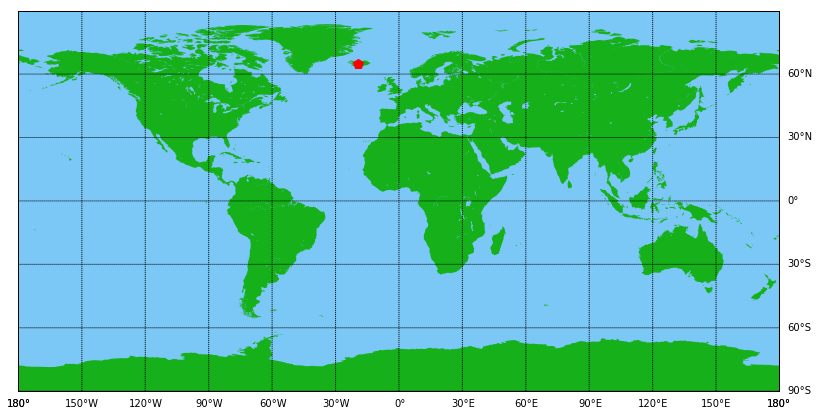

In [6]:
fig = plt.figure(figsize=(15,7))

#create a Basemap projection, cylindrical centered at 0
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')

# draw the oceans and countries and lines
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(0.,350.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])

# show my station
p1, = plt.plot(my_station['lon'],my_station['lat'],'rp', markersize=10)
plt.show()

## Detrending

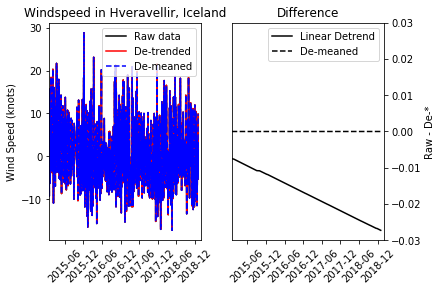

In [7]:
# daily demean
day_means = windspeed_series.groupby([(windspeed_series.index.month),(windspeed_series.index.day)]).transform('mean')
day_means = windspeed_series - day_means

# overall detrend
detrend_wind_lin = sig.detrend(day_means, type = 'linear')
detrend_wind_mean = sig.detrend(day_means, type = 'constant')

plt.subplot(1,2,1)
plt.plot(windspeed_series.index, day_means, color = 'k')
plt.plot(windspeed_series.index, detrend_wind_lin, color = 'r')
plt.plot(windspeed_series.index, detrend_wind_mean, color = 'b', linestyle = '--')
plt.xlim((pd.Timestamp(2015,1,1), pd.Timestamp(2019,2,1)))
plt.title('Windspeed in Hveravellir, Iceland')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=45)
plt.legend(('Raw data','De-trended','De-meaned'))

plt.subplot(1,2,2)
plt.plot(windspeed_series.index, day_means - detrend_wind_lin, color='k')
plt.plot(windspeed_series.index, day_means - detrend_wind_mean, color='k',linestyle='--')
plt.xlim((pd.Timestamp(2015,1,1), pd.Timestamp(2019,2,1)))
plt.xticks(rotation=45)
#plt.ylim((0.01, 0.05))
plt.gca().yaxis.tick_right()
plt.title('Difference')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Raw - De-*')
plt.legend(('Linear Detrend','De-meaned'))
plt.savefig('Iceland_Windspeed_DeTrended.pdf',bbox_inches='tight')
plt.show()

## Smoothing filters

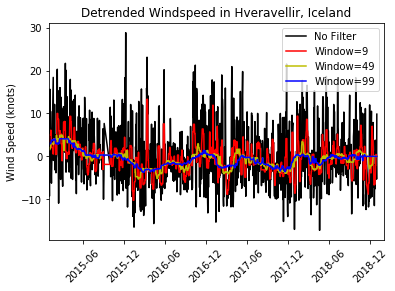

In [8]:
wind_medfilt10 = sig.medfilt(detrend_wind_lin, kernel_size = 9)
wind_medfilt50 = sig.medfilt(detrend_wind_lin, kernel_size = 49)
wind_medfilt100 = sig.medfilt(detrend_wind_lin, kernel_size = 99)

plt.plot(windspeed_series.index, detrend_wind_lin, color = 'k')
plt.plot(windspeed_series.index, wind_medfilt10, color = 'r')
plt.plot(windspeed_series.index, wind_medfilt50, color = 'y')
plt.plot(windspeed_series.index, wind_medfilt100, color = 'b')
plt.xlim((pd.Timestamp(2015,1,1), pd.Timestamp(2019,2,1)))
plt.title('Detrended Windspeed in Hveravellir, Iceland')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=45)
plt.legend(('No Filter','Window=9','Window=49','Window=99'))
plt.savefig('Iceland_Windspeed_SmoothedMedFilt.pdf',bbox_inches='tight')
plt.show()

## Select short section (10%) for example

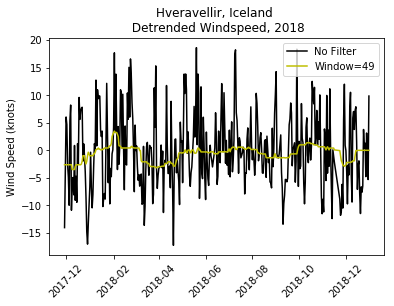

In [13]:
ntest = np.round(len(detrend_wind_lin)*0.9).astype(int)
test = detrend_wind_lin[ntest:]
ntrain = np.round(len(test)*0.9).astype(int)

plt.plot(windspeed_series[ntest:].index, test, color = 'k')
plt.plot(windspeed_series[ntest:].index, wind_medfilt50[ntest:], color = 'y')
plt.title('Hveravellir, Iceland \n Detrended Windspeed, 2018')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=45)
plt.legend(('No Filter','Window=49'))
plt.savefig('Iceland_Windspeed_Shortened.pdf',bbox_inches='tight')
plt.show()

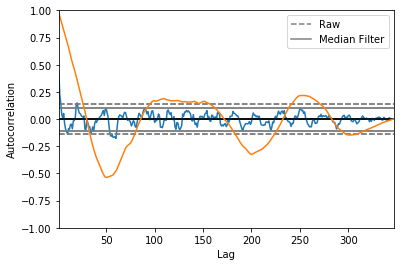

In [14]:
autocorrelation_plot(test[0:ntrain])
autocorrelation_plot(wind_medfilt50[ntest:][0:ntrain])
#plt.xlim((0,10))
plt.legend(('Raw','Median Filter'))
plt.savefig('Iceland_Windspeed_Stationarity_zoom.pdf',bbox_inches='tight')
plt.show()

# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# print(model_fit.summary())

In [ ]:
# # fit model
history = [X for X in test[0:ntrain]]
test_t = test[ntrain:]
model = ARMA(history, order=(3,1,2))
model_fit_pre = model.fit(disp=0)
pred = list()
for i in test_t:
    model = ARMA(history, order=(3,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    pred.append(output[0])
    history.append(i)

In [ ]:
plt.plot(windspeed_series[ntest:].index, test, color = 'k')
plt.plot(windspeed_series[ntest:][0:ntrain].index, test[0:ntrain] + model_fit_pre.resid, color = 'orange')
plt.plot(windspeed_series[ntest:][(ntrain-1):-1].index, pred, color = 'r',linestyle='--')
plt.title('Hveravellir, Iceland \n Detrended Windspeed, 2018')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=45)
plt.legend(('Raw','Training','Predict'))
plt.xlim((pd.Timestamp(2018,10,1), pd.Timestamp(2018,12, 31)))
#plt.savefig('Iceland_ARMA_predict.pdf',bbox_inches='tight')
plt.show()